In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import datetime as dt
from calendar import monthrange
import matplotlib.pyplot as plt

Что такое покупка.
Покупка -- это подтвержденный, т.е. оплаченный заказ (есть дата order_approved_at и статус не canceled),
потому что клиент может передумать.
Но дата покупки -- это дата принятия изначального решения о приобретении товара, потому что это -- дата, когда человек
задумывается о своей потребности, принимает решение (order_purchase_timestamp)
Таким образом, покупка -- это оплаченный заказ, но она совершена в момент создания заказа, а не оплаты.

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')

In [3]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
customers.shape

(99441, 5)

In [5]:
order_items = pd.read_csv('olist_order_items_dataset.csv')

In [6]:
order_items.shipping_limit_date = pd.to_datetime(order_items.shipping_limit_date)

In [7]:
order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [8]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


В этом датасете нет колонки с количеством товаров в заказе, но есть номер товара внутри заказа. Превратим ее в количество товаров в заказе. Ненужные колонки переносить в новый датасет не будем

In [9]:
order_items_amount = order_items.groupby('order_id', as_index=False). \
    agg({'order_item_id': 'max', 'price': 'sum'}).rename(columns={'order_item_id': 'items_amount'})

In [10]:
order_items_amount.shape

(98666, 3)

In [11]:
order_items_amount.order_id.nunique()

98666

In [12]:
orders = pd.read_csv('olist_orders_dataset.csv')

In [13]:
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
#у меня изменение типа работает только в таком порядке - сначала один столбец, потом остальные. 
#если сразу все, то ничего не меняется. если подскажете, почему, буду благодарна

In [14]:
orders.iloc[:, -5:] = orders.iloc[:, -5:].apply(pd.to_datetime)

In [15]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [16]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [17]:
df = customers.merge(orders, on='customer_id')

In [18]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [19]:
df1 = df.query("order_approved_at != 'NaT' & order_status != 'canceled'")

In [20]:
df1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [21]:
df1 = df1.groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'orders_amount'}) \
    .sort_values('orders_amount', ascending=False)

In [22]:
df1.query("orders_amount == 1")
# 92621 пользователей совершили только одну покупку

,customer_unique_id,orders_amount
61080,a386cfbe02fe676d118fb356ed6c0cc5,1
64212,abd388edf0df9d046ec7236bc00e89ce,1
64191,abc5d89f00acd3f067ea79119ddbf445,1
61082,a387d752d46438289df416efcb368aef,1
61083,a3891fed6f00343446b628f274125ee4,1
...,...,...
32310,564e41612fe5386af042e5f4977ffa28,1
32308,564cb124d13d16afc61936ea12a17c33,1
32307,564c03a40766b9b404572658fb74524d,1
32306,564bc02acd888f7617b0d7c737d35aee,1


Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [23]:
#тут ревь о количестве заказов, а не товаров, поэтому используем датасет по заказам без дублей
orders_summary = orders.merge(order_items_amount, on='order_id')

In [24]:
orders_summary.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,items_amount,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,19.90


In [25]:
orders_summary['EstMonth'] = orders_summary['order_estimated_delivery_date'].dt.month_name()
orders_summary['EstYear'] = orders_summary['order_estimated_delivery_date'].dt.year
#подготавливаю данные для группировки недоставленных товаров по месяцам. решила взять оценочную дату доставки,
 #т.к. даты НЕдоставки не существует

In [26]:
orders_summary.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,items_amount,price,EstMonth,EstYear
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,29.99,October,2017
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,118.70,August,2018
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,159.90,September,2018
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,45.00,December,2017
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,19.90,February,2018


In [27]:
#а сколько времени может пройти с покупки до доставки? нужно, чтобы понять, когда можно считать товар недоставленным
from_buy_to_deliver = orders_summary.order_delivered_customer_date - orders_summary.order_purchase_timestamp

In [28]:
from_buy_to_deliver.max()
#предположим, мы не будем бить рекорды по долгой доставке, и возбмем отсечку по максимальному историческому значению.
#но проверим, насколько мы оптимистичны и вычислим доверительный интервал для 95% значений

Timedelta('209 days 15:05:12')

In [29]:
from_buy_to_deliver = from_buy_to_deliver.dt.days

In [30]:
def mean_confidence_interval(a, confidence=0.95):
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a, nan_policy='omit')
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [31]:
mean_confidence_interval(from_buy_to_deliver)
#огромная разница! уже не хочется давать на доставку 209 дней. посмотрим другие метрики

(12.094085575687217, 12.03381205719233, 12.154359094182103)

In [32]:
from_buy_to_deliver.median()

10.0

In [33]:
from_buy_to_deliver.mean()

12.094085575687217

In [34]:
from_buy_to_deliver.quantile(0.95)

29.0

Максимальное значение является выбросом, и поэтому мы не будем ориентироваться на него.
Субъективно кажется разумным взять 95%-ный квантиль. Если товар не пришел спустя месяц после покупки - 
он не будет доставлен почти точно.
Проверим дату, примерно в которой живет наш аналитик, и заберем все заказы, которые не доставлены,
а месяц после покупки уже прошел

In [35]:
today = orders_summary.order_delivered_customer_date.max()

In [36]:
orders_summary['days_from_purchase'] = orders_summary.order_delivered_customer_date.max() - orders_summary.order_purchase_timestamp

In [37]:
orders_summary['days_from_purchase'] = orders_summary['days_from_purchase'].dt.days

In [38]:
not_delivered = orders_summary.query("days_from_purchase >= 29").query("order_delivered_customer_date == 'NaT'")

In [39]:
not_delivered.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,items_amount,price,EstMonth,EstYear,days_from_purchase
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,1,49.90,May,2017,554
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,1,14.49,June,2018,134
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,1,35.00,August,2018,74
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,1,125.90,October,2017,408
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,1,53.99,February,2018,280


In [40]:
#группируем по оценочной дате доставки
not_delivered.groupby(['EstYear','EstMonth']) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'orders_amount'})

orders_amount
EstYear EstMonth                
2016    December              24
        November              13
        October                3
2017    April                 77
        August                99
        December             161
        February               9
        July                  88
        June                 109
        March                124
        May                  107
        November              96
        October               90
        September            107
2018    April                173
        August               185
        February             134
        January               93
        July                  85
        June                  74
        March                182
        May                  153
        September              4

In [41]:
#и теперь с детализацией по причинам -- с этапами, на которых товар "застрял"
not_delivered.groupby(['EstYear','EstMonth', 'order_status']) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'orders_amount'})

orders_amount
EstYear EstMonth  order_status               
2016    December  canceled                  5
                  invoiced                  9
                  processing                2
                  shipped                   6
                  unavailable               2
...                                       ...
2018    May       canceled                 23
                  invoiced                 12
                  processing                6
                  shipped                 112
        September shipped                   4

[93 rows x 1 columns]

По каждому товару определить, в какой день недели товар чаще всего покупается.

In [42]:
#Здесь речь о товарах, а не заказах, поэтому нужно сохранить дубли
order_products_amount = order_items.groupby(['order_id', \
    'product_id', 'shipping_limit_date'], as_index=False). \
    agg({'seller_id': 'count'}).rename(columns={'seller_id': 'items_amount'})

In [43]:
order_products_amount.sort_values('items_amount', ascending=False)

,order_id,product_id,shipping_limit_date,items_amount
10850,1b15974a0141d54e36626dca3fdc731a,ee3d532c8a438679776d222e997606b3,2018-03-01 02:50:48,20
68186,ab14fdcfbe524636d65ee38360e22ce8,9571759451b1d780ee7c15012ea109d4,2017-08-30 14:30:23,20
26550,428a2f660dc84138d969ccd69a0ab6d5,89b190a046022486c635022524a974a8,2017-11-30 10:30:51,15
63242,9ef13efd6949e4573a18964dd1bbe7f5,37eb69aca8718e843d897aa7b82f462d,2017-02-03 21:44:49,15
46268,73c8ab38f07dc94389065f7eba4f297a,422879e10f46682990de24d770e7f83d,2017-12-21 02:30:41,14
...,...,...,...,...
35388,5897449bce69856d88610b3c0f4f63b5,b0364648b1c062169015d9234d97d306,2017-01-19 21:46:43,1
35387,5896d753079d9faa8aeaf60231b3e788,cce679660c66e6fbd5c8091dfd29e9cd,2017-10-02 09:45:36,1
35386,589673b4d98b5c40931ac6a6ff6f3416,fe01b643060a6446e59f58e3021e66b3,2018-06-19 16:32:32,1
35385,5895d82d31799f8d7ad6748c25e76dad,24c66f106f642621e524291a895c9032,2018-06-12 00:55:28,1


In [44]:
products_summary = orders.merge(order_products_amount, on='order_id')

In [45]:
products_summary['DayOfWeek'] = products_summary['order_purchase_timestamp'].dt.day_name()

In [46]:
products = products_summary.query("order_approved_at != 'NaT'") \
    .groupby(['product_id', 'DayOfWeek']) \
    .agg({'items_amount': 'sum'}) \
    .sort_values('items_amount', ascending=False) \
    .rename(columns={'items_amount': 'buys_amount'})

In [47]:
products.groupby(level=0).head(1)

,,buys_amount
product_id,DayOfWeek,
422879e10f46682990de24d770e7f83d,Wednesday,93
99a4788cb24856965c36a24e339b6058,Monday,92
aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...
642247ccf62585635cefa1bf09f59b94,Sunday,1
642e125cbc752b4eeb8faf442319c39f,Thursday,1
6432d844f2be41bb6f2fd279e23415da,Friday,1


Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца 
может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [48]:
#фильтруем по состоявшимся покупкам
buys_df = df.query("order_approved_at != 'NaT' & order_status != 'canceled'")

In [49]:
buys_df['BuyMonth'] = buys_df.order_purchase_timestamp.apply(lambda x: x.strftime("%Y, %m"))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
buys_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,BuyMonth
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,"2017, 05"
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,"2018, 01"
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,"2018, 05"
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,"2018, 03"
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,"2018, 07"


In [51]:
buys_by_month = buys_df.groupby(['customer_unique_id', 'BuyMonth'], as_index=False) \
    .agg({'customer_city': 'count'}).rename(columns={'customer_city': 'buys_amount'}) \
    .sort_values('buys_amount', ascending=False)

In [52]:
buys_by_month

,customer_unique_id,BuyMonth,buys_amount
7273,12f5d6e1cbf93dafd9dcc19095df0b3d,"2017, 01",6
23795,3e43e6105506432c953e165fb2acf44c,"2018, 02",4
50309,83e7958a94bd7f74a9414d8782f87628,"2017, 01",4
67336,b08fab27d47a1eb6deda07bfd965ad43,"2017, 09",4
68962,b4e4f24de1e8725b74e4a1f4975116ed,"2018, 02",4
...,...,...,...
32662,5596da0d33997ed7cd9020fa7af0649b,"2017, 07",1
32661,559620bb304bfa901a54939d04dd203f,"2018, 01",1
32660,5595fb3aa8c496ff254d154b263e80cd,"2018, 03",1
32659,5595cc8e21946d81a82054dea257108a,"2018, 07",1


In [53]:
buys_by_month['daysInMonth'] = buys_by_month.BuyMonth.apply(lambda x: monthrange(int(x[0:4]), int(x[6:8])))

In [54]:
buys_by_month['daysInMonth'] = buys_by_month.daysInMonth.apply(lambda x: int(x[1]))

In [55]:
buys_by_month.head()

,customer_unique_id,BuyMonth,buys_amount,daysInMonth
7273,12f5d6e1cbf93dafd9dcc19095df0b3d,"2017, 01",6,31
23795,3e43e6105506432c953e165fb2acf44c,"2018, 02",4,28
50309,83e7958a94bd7f74a9414d8782f87628,"2017, 01",4,31
67336,b08fab27d47a1eb6deda07bfd965ad43,"2017, 09",4,30
68962,b4e4f24de1e8725b74e4a1f4975116ed,"2018, 02",4,28


In [56]:
buys_by_month['BuysPerWeek'] = buys_by_month.buys_amount / (buys_by_month.daysInMonth / 7)

In [57]:
buys_by_month

,customer_unique_id,BuyMonth,buys_amount,daysInMonth,BuysPerWeek
7273,12f5d6e1cbf93dafd9dcc19095df0b3d,"2017, 01",6,31,1.354839
23795,3e43e6105506432c953e165fb2acf44c,"2018, 02",4,28,1.000000
50309,83e7958a94bd7f74a9414d8782f87628,"2017, 01",4,31,0.903226
67336,b08fab27d47a1eb6deda07bfd965ad43,"2017, 09",4,30,0.933333
68962,b4e4f24de1e8725b74e4a1f4975116ed,"2018, 02",4,28,1.000000
...,...,...,...,...,...
32662,5596da0d33997ed7cd9020fa7af0649b,"2017, 07",1,31,0.225806
32661,559620bb304bfa901a54939d04dd203f,"2018, 01",1,31,0.225806
32660,5595fb3aa8c496ff254d154b263e80cd,"2018, 03",1,31,0.225806
32659,5595cc8e21946d81a82054dea257108a,"2018, 07",1,31,0.225806


ответ - в BuysPerWeek

Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту
с самым высоким retention на 3й месяц.

In [58]:
buys_df['BuyMonth1'] = buys_df["order_purchase_timestamp"].apply(lambda x: x.strftime("%Y-%m-01"))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
buys_df['BuyMonth1'] = pd.to_datetime(buys_df['BuyMonth1'])

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
buys_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,BuyMonth,BuyMonth1
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,"2017, 05",2017-05-01
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,"2018, 01",2018-01-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,"2018, 05",2018-05-01
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,"2018, 03",2018-03-01
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,"2018, 07",2018-07-01


In [61]:
start_date = buys_df.groupby('customer_unique_id')['BuyMonth1'].min()

In [62]:
start_date.head()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2   2018-05-01
0000b849f77a49e4a4ce2b2a4ca5be3f   2018-05-01
0000f46a3911fa3c0805444483337064   2017-03-01
0000f6ccb0745a6a4b88665a16c9f078   2017-10-01
0004aac84e0df4da2b147fca70cf8255   2017-11-01
Name: BuyMonth1, dtype: datetime64[ns]

In [63]:
start_date = start_date.rename("start_date")

In [64]:
for_cohort = pd.merge(buys_df, start_date, left_on='customer_unique_id', right_index=True)
for_cohort = for_cohort.sort_values('order_purchase_timestamp')

In [65]:
for_cohort['months_since_start'] = (for_cohort['BuyMonth1'] - for_cohort['start_date']) / np.timedelta64(1, 'M')

In [66]:
for_cohort['months_since_start'] = for_cohort['months_since_start'].round()

In [67]:
for_cohort.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,BuyMonth,BuyMonth1,start_date,months_since_start
84697,08c5351a6aca1c1589a38f244edeee9d,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,"2016, 09",2016-09-01,2016-09-01,0.0
21125,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,"2016, 09",2016-09-01,2016-09-01,0.0
38634,355077684019f7f60a031656bd7262b8,32ea3bdedab835c3aa6cb68ce66565ef,4106,sao paulo,SP,3b697a20d9e427646d92567910af6d57,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,2016-10-23 14:02:13,2016-10-26 14:02:13,2016-10-27,"2016, 10",2016-10-01,2016-10-01,0.0
55191,7ec40b22510fdbea1b08921dd39e63d8,2f64e403852e6893ae37485d5fcacdaf,98280,panambi,RS,be5bc2f0da14d8071e2d45451ad119d9,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,2016-10-21 16:33:46,2016-10-27 18:19:38,2016-11-07,"2016, 10",2016-10-01,2016-10-01,0.0
7739,6f989332712d3222b6571b1cf5b835ce,61db744d2f835035a5625b59350c6b63,90040,porto alegre,RS,a41c8759fbe7aab36ea07e038b2d4465,delivered,2016-10-03 21:13:36,2016-10-05 03:11:49,2016-10-25 11:57:59,2016-11-03 10:58:07,2016-11-29,"2016, 10",2016-10-01,2016-10-01,0.0


In [68]:
retention_cohort_all = pd.DataFrame(columns=['x', 'm'])
for i, month in enumerate(for_cohort['start_date'].unique()):
    
    # For each month, create a cohort df (dfc) that is filtered just for that month
    dfc = for_cohort[for_cohort['start_date']==pd.to_datetime(month)]

    # Then get your retention corhorts for that start month
    retention_cohort = dfc.groupby('months_since_start')['customer_unique_id'].nunique() / dfc['customer_unique_id'].nunique()
    retention_cohort_all = pd.concat([retention_cohort_all, retention_cohort], axis=1)
    month = month
    retention_cohort_all = retention_cohort_all.rename(columns={'customer_unique_id': month})

In [69]:
retention_cohort_all = retention_cohort_all.drop(['x', 'm'], axis=1)

In [70]:
retention_cohort_all.head()

,2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
0.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,NaN,NaN,1.0,0.003947,0.002322,0.004994,0.005998,0.004761,0.004479,0.005171,...,0.005504,0.002556,0.003289,0.003604,0.004175,0.005821,0.005152,0.004221,0.005138,0.000161
2.0,NaN,NaN,NaN,0.002632,0.002902,0.003458,0.002142,0.005041,0.003519,0.003361,...,0.003853,0.002739,0.003719,0.003917,0.003023,0.003134,0.002576,0.002701,NaN,NaN
3.0,NaN,NaN,NaN,0.001316,0.001161,0.003842,0.001714,0.003920,0.004159,0.002585,...,0.001651,0.003469,0.002860,0.002977,0.002879,0.002388,0.001970,NaN,NaN,NaN
4.0,NaN,NaN,NaN,0.003947,0.004063,0.003458,0.002999,0.003080,0.002559,0.002844,...,0.001926,0.002739,0.002860,0.002664,0.001296,0.001343,NaN,NaN,NaN,NaN


In [71]:
retention_cohort_all.iloc[2]
#В период с января по декабрь когорта с самым высоким retention на 3й месяц -- 2017-09 -- 0.005350

2016-09-01T00:00:00.000000000         NaN
2016-10-01T00:00:00.000000000         NaN
2016-12-01T00:00:00.000000000         NaN
2017-01-01T00:00:00.000000000    0.002632
2017-02-01T00:00:00.000000000    0.002902
2017-03-01T00:00:00.000000000    0.003458
2017-04-01T00:00:00.000000000    0.002142
2017-05-01T00:00:00.000000000    0.005041
2017-06-01T00:00:00.000000000    0.003519
2017-07-01T00:00:00.000000000    0.003361
2017-08-01T00:00:00.000000000    0.003364
2017-09-01T00:00:00.000000000    0.005350
2017-10-01T00:00:00.000000000    0.002474
2017-11-01T00:00:00.000000000    0.003853
2017-12-01T00:00:00.000000000    0.002739
2018-01-01T00:00:00.000000000    0.003719
2018-02-01T00:00:00.000000000    0.003917
2018-03-01T00:00:00.000000000    0.003023
2018-04-01T00:00:00.000000000    0.003134
2018-05-01T00:00:00.000000000    0.002576
2018-06-01T00:00:00.000000000    0.002701
2018-07-01T00:00:00.000000000         NaN
2018-08-01T00:00:00.000000000         NaN
Name: 2.0, dtype: float64

In [72]:
buys_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,BuyMonth,BuyMonth1
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,"2017, 05",2017-05-01
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,"2018, 01",2018-01-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,"2018, 05",2018-05-01
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,"2018, 03",2018-03-01
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,"2018, 07",2018-07-01


Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию

In [73]:
#снова берем датасет без дублей по товарам, т.к. Frequency -- это частота отдельных покупок,
#показатель, возвращался ли пользователь в другое время
summary = customers.merge(orders_summary, on='customer_id')

In [74]:
summary['buy_date'] = summary["order_purchase_timestamp"].apply(lambda x: x.strftime("%Y-%m-%d"))

In [75]:
summary['buy_date'] = pd.to_datetime(summary['buy_date'])

In [76]:
summary.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,items_amount,price,EstMonth,EstYear,days_from_purchase,buy_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,124.99,June,2017,518,2017-05-16
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,289.00,February,2018,277,2018-01-12
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,139.94,June,2018,150,2018-05-19
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,149.94,April,2018,217,2018-03-13
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,230.00,August,2018,80,2018-07-29


In [77]:
summary.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'canceled',
       'unavailable', 'approved'], dtype=object)

In [78]:
summary_buys = summary.query("order_approved_at != 'NaT' & order_status != 'canceled'")

In [79]:
summary_buys.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,items_amount,price,EstMonth,EstYear,days_from_purchase,buy_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,124.99,June,2017,518,2017-05-16
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,289.00,February,2018,277,2018-01-12
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,139.94,June,2018,150,2018-05-19
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,149.94,April,2018,217,2018-03-13
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,230.00,August,2018,80,2018-07-29


In [80]:
orders_agg = summary_buys.groupby(['order_id', 'buy_date', 'customer_unique_id']). \
    agg({'price': lambda x: (x*summary_buys.items_amount).sum()}).reset_index()
orders_agg.head()

,order_id,buy_date,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,871766c5855e863f6eccc05f988b23cb,58.90
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26,eb28e67c4c0b83846050ddfb8a35d051,239.90
2,000229ec398224ef6ca0657da4fc703e,2018-01-14,3818d81c6709e39d06b2738a8d3a2474,199.00
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08,af861d436cfc08b2c2ddefd0ba074622,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04,64b576fb70d441e8f1b2d7d446e483c5,199.90


In [81]:
NOW = summary_buys['buy_date'].max() + dt.timedelta(days=1)
NOW

Timestamp('2018-09-04 00:00:00')

In [82]:
summary_buys['days_since_order'] = summary_buys['buy_date'].apply(lambda x: (NOW - x).days)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
#aggr = {
 #   'days_since_order': lambda x: x.min(),  # the number of days since last order (Recency)
  #  'buy_date': lambda x: len([d for d in x if d >= NOW - dt.timedelta(days=period)]), # the total number of orders in the last period (Frequency)
#}
#rfm = summary_buys.groupby('customer_unique_id').agg(aggr).reset_index()
#rfm.rename(columns={'days_since_order': 'Recency', 'buy_date': 'Frequency'}, inplace=True)
#rfm.head()

In [84]:
aggr = {
    'days_since_order': lambda x: x.min(),  # the number of days since last order (Recency)
    'buy_date': lambda x: len([d for d in x]), # the total number of orders in the last period (Frequency)
}
rfm = summary_buys.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'days_since_order': 'Recency', 'buy_date': 'Frequency'}, inplace=True)
rfm.head()

,customer_unique_id,Recency,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1
2,0000f46a3911fa3c0805444483337064,543,1
3,0000f6ccb0745a6a4b88665a16c9f078,327,1
4,0004aac84e0df4da2b147fca70cf8255,294,1


In [85]:
rfm['Monetary'] = rfm['customer_unique_id'].apply(lambda x: summary_buys[(summary_buys['customer_unique_id'] == x)]\
                                                           ['price'].sum())
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90
2,0000f46a3911fa3c0805444483337064,543,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00


In [126]:
rfm.Frequency.quantile(.97)
#96% покупателей совершали только одну покупку. дробить оставшиеся 4% на разные сегменты кажется нелогичным, поэтому по F
#будет только одна отсечка

2.0

In [87]:
quintiles = rfm[['Recency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 99.0, 0.4: 183.0, 0.6: 274.0, 0.8: 389.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [88]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def f_score(x, c):
    if x == 1:
        return 1
    else:
        return 2  
    
def m_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5 

In [89]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x, 'Monetary'))

In [90]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,1,5,215


In [91]:
rfm['RFM Score'].unique()

array(['414', '411', '112', '211', '215', '315', '114', '413', '111',
       '213', '412', '311', '512', '511', '515', '115', '214', '113',
       '313', '513', '212', '514', '415', '314', '325', '312', '423',
       '523', '123', '425', '525', '225', '125', '422', '223', '324',
       '524', '222', '424', '322', '521', '122', '522', '224', '124',
       '323', '421', '221', '321', '121'], dtype=object)

In [127]:
segt_map = {
    r'[1-2]1[1-5]': 'hibernating', #не стала делить спящих по сумме потраченных денег, т.к. все равно спят
    r'[1-3]2[1-5]': 'can\'t loose', #тоже не стала делить по деньгам, т.к. две покупки это редкость
    r'31[1-3]': 'about to sleep',
    r'31[4-5]': 'spenders about to sleep', #здесь количество денег может иметь значение, т.к. клиенты еще не спят
    r'32[1-3]': 'need attention',
    r'41[1-5]': 'promising',
    
    r'51[1-3]': 'new customers',
    r'51[4-5]': 'new customers spenders', #здесь количество денег может иметь значение, т.к. клиенты новые и на них можно повлиять
    r'[4-5]2[1-5]': 'champions',
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)+ rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,4,1,1,411,411
2,0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,2,112,112
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,1,1,211,211
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,1,5,215,215


In [128]:
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,4,1,1,411,promising
2,0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,1,1,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,1,5,215,hibernating


In [129]:
rfm['Segment'].unique()

array(['promising', 'hibernating', 'spenders about to sleep',
       'about to sleep', 'new customers', 'new customers spenders',
       "can't loose", 'champions'], dtype=object)

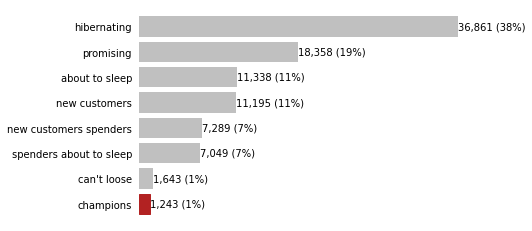

In [130]:
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Описание сегментов

hibernating - Recency 1-183 дней, Frequency 1 покупка, Monetary любое.
can't loose - Recency 100-274 дня, Frequency > 1 покупки, Monetary любое.
about to sleep - Recency 183-274 дня, Frequency 1 покупка, Monetary 1-274 у.е.
spenders about to sleep - Recency 183-274 дня, Frequency 1 покупка, Monetary > 274 у.е.
need attention - Recency 183-274 дня, Frequency 2 покупки, Monetary 1-274 у.е.
promising- Recency 274-389 дней, Frequency 1 покупка, Monetary любое
new customers - Recency < 389 дней, Frequency 1 покупка, Monetary 1-274 у.е.
new customers spenders - Recency < 389 дней, Frequency 1 покупка, Monetary > 274 у.е.
champions - Recency 274-389 дней, Frequency 2 покупки, Monetary любое

